# Preare Packages

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!rm -rf efficientdet
!git clone https://github.com/manhlab/efficientdet

Cloning into 'efficientdet'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 66 (delta 16), reused 59 (delta 11), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [ ]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

     | 399kB 7.5MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=5b701693d2314ffd1859fbe96a871cf5eac88d75e268d03e9904f6d42e373fba
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ts181bh/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
!pip install timm
!pip install pycocotools
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!git clone https://github.com/omry/omegaconf.git
!git clone https://github.com/NVIDIA/apex
!pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/
!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7_53-6d1d7a95.pth
!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d6-51cb0132.pth
!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d5-ef44aea8.pth

     |████████████████████████████████| 215kB 2.8MB/s 
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-gowxdl3i
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-gowxdl3i
     |████████████████████████████████| 952kB 2.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65436 sha256=f166723f985c657c7da78556e20cf2c9e28f294809a3745638a61e27b5e5d5db
  Stored in directory: /tmp/pip-ephem-wheel-cache-p2i4xca2/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-

In [ ]:
#@title
from shutil import copyfile
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
! cp "/content/gdrive/My Drive/EFD/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c global-wheat-detection
! unzip global-wheat-detection.zip -d data/

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=0db868cba3e187e995d692ccc79bada4bd3afe1d3308e9c43ca3afa2eb11614b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
 99% 601M/607M [00:11<00:00, 88.9MB/s]
100% 607M/607M [00:11<00:00, 53.5MB/s]
Archive:  global-wheat-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/test/2fd875eaa.jpg  
  inflating: data/test/348a992bb.jpg  
  inflating: data/test/51b3e36ab.jpg  
  inflating: data/test/51f1be19e.jpg  
  inflating: data/test/53f253011.jpg  
  inflating: data/test/796707dd7.jpg  
  inflating: data/test/aac893a91.jpg  
  inflating: data/test/cb8d261a3.jpg  
  inflating: data/test/cc3532ff6.jpg  
  inflating: data/test/f5a1f0358.jp

In [ ]:
! cp "/content/gdrive/My Drive/EFD/data_split.csv" data
! cp "/content/gdrive/My Drive/EFD/train.csv" data

# Import packages and prepare data

In [ ]:
import sys
sys.path.insert(0, "/content/efficientdet")
sys.path.insert(0, "/content/omegaconf")

import torch
import os
from datetime import datetime
import math
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import torchsummary
from effdet.myutils import *
from tqdm.auto import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from warmup_scheduler import GradualWarmupScheduler
from prefetch_generator import BackgroundGenerator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SEED = 42
seed_everything(SEED)

In [ ]:
marking = pd.read_csv('/content/data/train.csv')
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

df_folds = pd.read_csv('/content/data/data_split.csv')

In [4]:
TRAIN_ROOT_PATH = '/content/data/train'

fold_number = 0

train_dataset = DatasetRetriever(
  image_ids=df_folds[df_folds['fold'] != fold_number].image_id.values,
  marking=marking,
  data_path=TRAIN_ROOT_PATH,
  transforms=get_train_transforms(),
  test=False,
  cache=True
)


validation_dataset = DatasetRetriever(
  image_ids=df_folds[df_folds['fold'] == fold_number].image_id.values,
  marking=marking,
  data_path=TRAIN_ROOT_PATH,
  transforms=get_valid_transforms(),
  test=True,
  cache=True
)


## check if it works

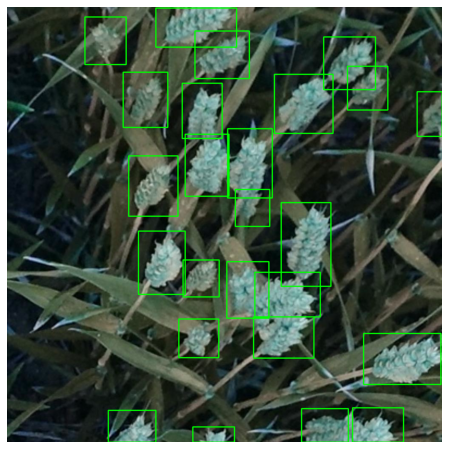

In [5]:
image, target, image_id = validation_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
  cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

# Config and some functions

In [6]:
class TrainGlobalConfig:
  folder = 'run'
  num_workers = 4
  batch_size = 2
  num_classes = 1
  n_epochs = 40 # n_epochs = 40
  lr = 0.005
  accumulate = 16
  apex = True
  img_size = 1024
  debug = False

  verbose = True
  verbose_step = 1

  SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingLR
  scheduler_params = {
    'T_max':40,
    'eta_min':1e-9
  }

  step_scheduler = False  # do scheduler.step after optimizer.step
  validation_scheduler = False  # do scheduler.step after validation stage loss
  warmup = True # do scheduler.step every batch!

  


In [7]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(net):
  device = torch.device('cuda:0')
  net.to(device)

  train_loader = DataLoaderX(
      train_dataset,
      batch_size=TrainGlobalConfig.batch_size,
      sampler=RandomSampler(train_dataset),
      pin_memory=False,
      drop_last=True,
      num_workers=TrainGlobalConfig.num_workers,
      collate_fn=collate_fn,
  )
  val_loader = DataLoaderX(
      validation_dataset, 
      batch_size=TrainGlobalConfig.batch_size,
      num_workers=TrainGlobalConfig.num_workers,
      shuffle=False,
      sampler=SequentialSampler(validation_dataset),
      pin_memory=False,
      collate_fn=collate_fn,
  )

  fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
  fitter.fit(train_loader, val_loader)

def get_net():
  config = get_efficientdet_config('tf_efficientdet_d7')
  net = EfficientDet(config, pretrained_backbone=False)
  checkpoint = torch.load('/content/tf_efficientdet_d7_53-6d1d7a95.pth')
  net.load_state_dict(checkpoint)
  config.num_classes = 1
  config.image_size = 1024
  net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
  return DetBenchTrain(net, config)

# get and train the model

In [9]:
net = get_net()

In [ ]:
run_training(net)

Fitter prepared. Device is cuda:0
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic

2020-07-24T04:55:35.587637
LR: 0.0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0

[RESULT]: Train. Epoch: 0, summary_loss: 18.60841, time: 1622.27251



[RESULT]: Val. Epoch: 0, summary_loss: 42.47393, time: 116.89577

2020-07-24T05:24:35.417181
LR: 0.0



[RESULT]: Train. Epoch: 1, summary_loss: 1.93618, time: 1623.15040



[RESULT]: Val. Epoch: 1, summary_loss: 1.40346, time: 116.82302

2020-07-24T05:53:36.066228
LR: 0.001



[RESULT]: Train. Epoch: 2, summary_loss: 0.85893, time: 1624.97379



[RESULT]: Val. Epoch: 2, summary_loss: 0.67374, time: 116.90385

2020-07-24T06:22:38.608389
LR: 0.002



[RESULT]: Train. Epoch: 3, summary_loss: 0.74315, time: 1624.93511



[RESULT]: Val. Epoch: 3, summary_loss: 0.56185, time: 116.93975

2020-07-24T06:51:41.162043
LR: 0.003



[RESULT]: Train. Epoch: 4, summary_loss: 0.68458, time: 1625.81820



[RESULT]: Val. Epoch: 4, summary_loss: 0.51200, time: 117.15876

2020-07-24T07:20:44.844665
LR: 0.004



[RESULT]: Train. Epoch: 5, summary_loss: 0.65343, time: 1626.90740



[RESULT]: Val. Epoch: 5, summary_loss: 0.48862, time: 117.20439

2020-07-24T07:49:49.632708
LR: 0.005


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0

[RESULT]: Train. Epoch: 6, summary_loss: 0.63266, time: 1627.65167



[RESULT]: Val. Epoch: 6, summary_loss: 0.47511, time: 117.26622

2020-07-24T08:18:55.240178
LR: 0.005



[RESULT]: Train. Epoch: 7, summary_loss: 0.61377, time: 1628.17471



[RESULT]: Val. Epoch: 7, summary_loss: 0.46501, time: 117.29086

2020-07-24T08:48:01.373120
LR: 0.004969220857643674


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0

[RESULT]: Train. Epoch: 8, summary_loss: 0.60180, time: 1627.13574



[RESULT]: Val. Epoch: 8, summary_loss: 0.46104, time: 117.37289

2020-07-24T09:17:06.564368
LR: 0.004930924814809231


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0

[RESULT]: Train. Epoch: 9, summary_loss: 0.59307, time: 1627.05820



[RESULT]: Val. Epoch: 9, summary_loss: 0.46193, time: 117.34500

2020-07-24T09:46:11.305382
LR: 0.004877641315209626



[RESULT]: Train. Epoch: 10, summary_loss: 0.58619, time: 1626.94916



[RESULT]: Val. Epoch: 10, summary_loss: 0.45347, time: 117.45029

2020-07-24T10:15:16.489022
LR: 0.0048096988693384505


In [ ]:
!cp -r run '/content/gdrive/My Drive/EFD/'

In [ ]:
!nvidia-smi

Tue Jul 21 17:42:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ps -elf | grep python

4 S root          18       8  0  80   0 - 123844 epoll_ 16:58 ?       00:00:05 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
4 S root        1158      18  6  80   0 - 8272233 select 17:36 ?      00:00:15 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-f5caaa09-8322-44a0-a7c3-86a07445fe37.json
1 S root        1208    1158  0  80   0 - 4735941 sys_po 17:37 ?      00:00:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-f5caaa09-8322-44a0-a7c3-86a07445fe37.json
1 S root        1209    1158  0  80   0 - 4735944 sys_po 17:37 ?      00:00:00 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-f5caaa09-8322-44a0-a7c3-86a07445fe37.json
0 S root        1265    1158  0  80   0 -  9799 wait   17:40 ?        00:00:00 /bin/bash -c ps -elf | grep python
0 S root        1267    1265  0  80

In [ ]:
!kill -9 1158 1208 1209